# Exploratory Data Analysis

In the following, I analyze the dataset underlying the ML model for scheduling standby drivers.
<br>
I want to clarify which variables are interrelated, how they are distributed and thus find out which ones are suitable for the model as features.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

### Load and inspect the data:

In [2]:
df = pd.read_csv('/Users/kata/Desktop/GitHub/standby_duty_forecasting/sickness_table.csv', index_col=0)

In [3]:
df.head()

,date,n_sick,calls,n_duty,n_sby,sby_need,dafted
0,2016-04-01,73,8154.0,1700,90,4.0,0.0
1,2016-04-02,64,8526.0,1700,90,70.0,0.0
2,2016-04-03,68,8088.0,1700,90,0.0,0.0
3,2016-04-04,71,7044.0,1700,90,0.0,0.0
4,2016-04-05,63,7236.0,1700,90,0.0,0.0


* **date:** entry date
* **n_sick:** number of drivers called sick on duty
* **calls:** number of emergency calls
* **n_duty:** number of drivers on duty available
* **n_sby:** number of standby resources available
* **sby_need:** number of standbys, which are activated on a given day
* **dafted:** number of additional drivers needed due to not enough standbys

Let's look at numerical summaries:

In [38]:
df.describe(include = 'all')

,date,n_sick,calls,n_duty,n_sby,sby_need,dafted
count,1152,1152.000000,1152.000000,1152.000000,1152.0,1152.000000,1152.000000
unique,1152,NaN,NaN,NaN,NaN,NaN,NaN
top,2016-09-09,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,68.808160,7919.531250,1820.572917,90.0,34.718750,16.335938
std,NaN,14.293942,1290.063571,80.086953,0.0,79.694251,53.394089
min,NaN,36.000000,4074.000000,1700.000000,90.0,0.000000,0.000000
25%,NaN,58.000000,6978.000000,1800.000000,90.0,0.000000,0.000000
50%,NaN,68.000000,7932.000000,1800.000000,90.0,0.000000,0.000000
75%,NaN,78.000000,8827.500000,1900.000000,90.0,12.250000,0.000000


Check for NaN-values:

In [5]:
df[df.isnull().any(axis=1)]

,date,n_sick,calls,n_duty,n_sby,sby_need,dafted


So sehen die Were in verschiedenen Spalten aus:

In [35]:
df.n_duty.unique()

array([1700, 1800, 1900])

This means, there is only three options of drivers on duty. The values increase over time.

In [36]:
df.n_sby.unique()

array([90])

There are always 90 drivers on standby.

In [39]:
print(df.date.min())
print(df.date.max())

2016-04-01
2019-05-27


The data covers a period of three years, from April 1st 2016 to May 27th 2019.

In [40]:
print(df.calls.min())
print(df.calls.max())
print(df.calls.mean())

4074.0
11850.0
7919.53125


At least 4074 calls were received during the period, maximum 11.850. On average, 7919.53 calls were received.

In [41]:
print(df.sby_need.min())
print(df.sby_need.max())
print(df.sby_need.mean())

0.0
555.0
34.71875


On average, 34.7 drivers are needed on standby. However, since the maximum is 555, it is worth looking for outliers here.

Correlation matrix between all the features we are examining and our y-variable:

In [6]:
corr = df.corr()
print(corr)

            n_sick     calls    n_duty  n_sby  sby_need    dafted
n_sick    1.000000  0.155371  0.459501    NaN  0.022321  0.016800
calls     0.155371  1.000000  0.364135    NaN  0.677468  0.557340
n_duty    0.459501  0.364135  1.000000    NaN  0.090654  0.084955
n_sby          NaN       NaN       NaN    NaN       NaN       NaN
sby_need  0.022321  0.677468  0.090654    NaN  1.000000  0.945168
dafted    0.016800  0.557340  0.084955    NaN  0.945168  1.000000


### Investigate graphically

Make pairplots to investigate data further and spot correlations:

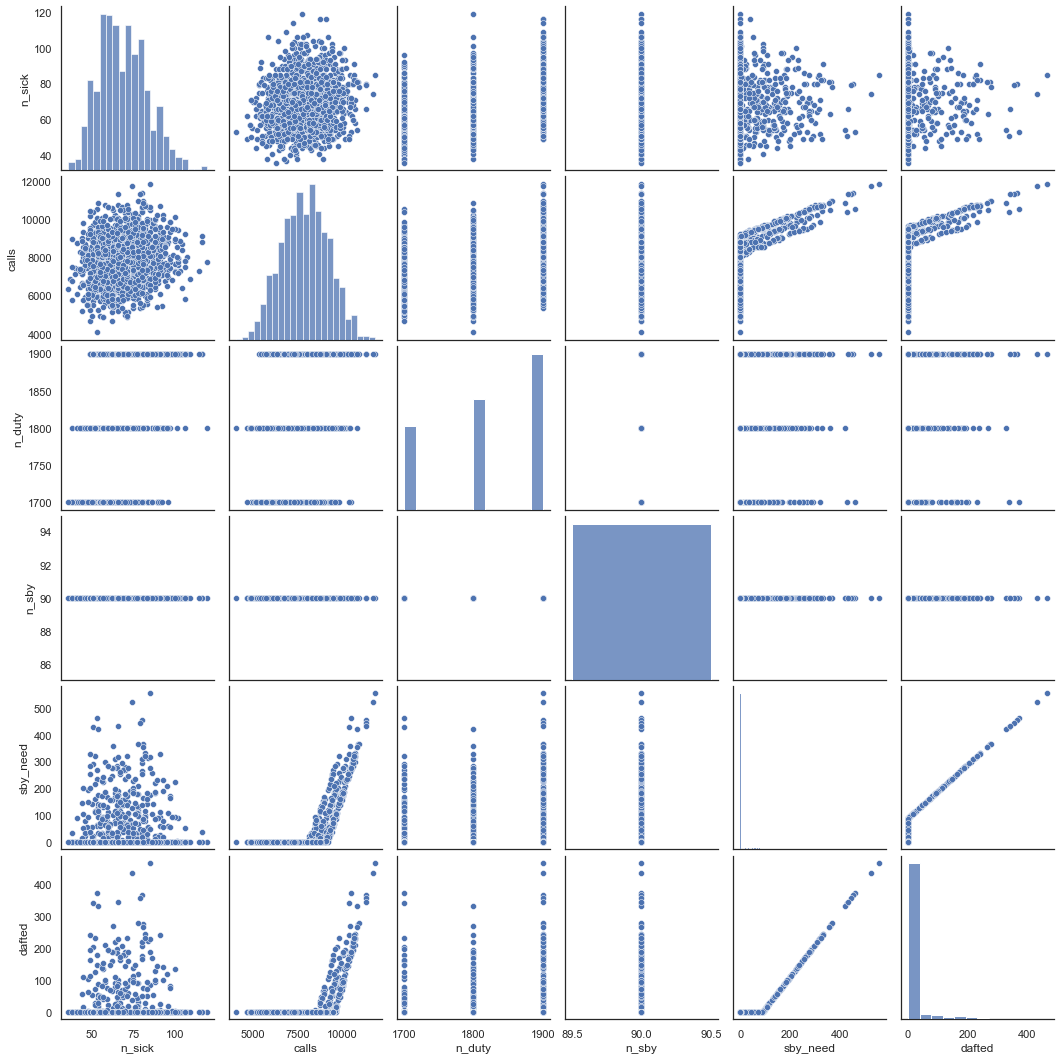

In [9]:
sns.set_theme(style="white")

sns.pairplot(df)

The distribution of "sby_need" looks interesting, this is how the histogram looks in detail:

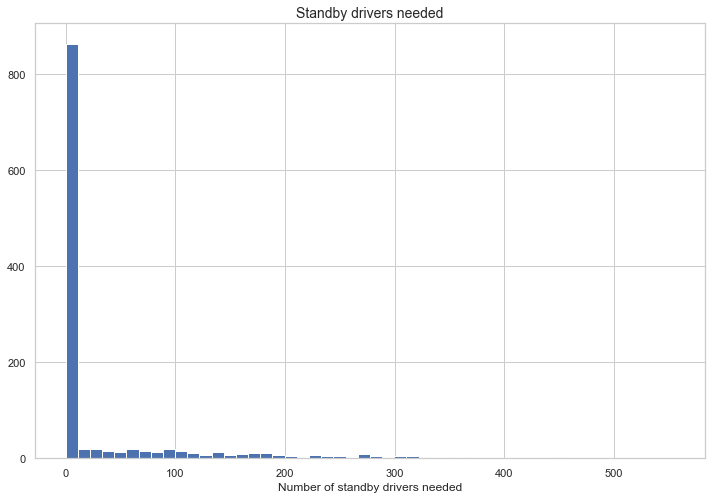

In [47]:
plt.figure(figsize=(12, 8))
plt.clf()
plt.hist(df.sby_need, bins=50)
plt.title('Standby drivers needed', fontsize=14)
plt.xlabel('Number of standby drivers needed')
plt.show()

In [17]:
new_df2 = df.groupby(['sby_need']).size()
print(new_df2)

sby_need
0.0      849
2.0        3
4.0        4
5.0        1
6.0        2
        ... 
445.0      1
454.0      1
461.0      1
523.0      1
555.0      1
Length: 185, dtype: int64


Standby drivers were not needed in nearly three-quarters of the cases. However, there are also individual cases in which several hundred were needed.
<br>
Another graphic will illustrate this.

<Figure size 1008x576 with 0 Axes>

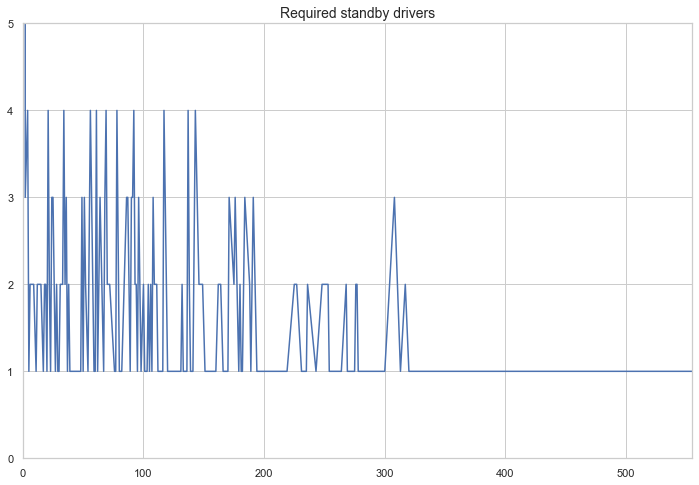

In [53]:
# needed???
plt.clf()
plt.figure(figsize=(12, 8))
plt.plot(new_df2)
plt.axis([0, 555, 0, 5])
plt.title('Required standby drivers', fontsize=14)
plt.show()

Most of the time no standby drivers were needed, otherwise between 2 and 5. It could become problematic that there are numerous individual cases where hundreds were needed.

Visualize data over the years:

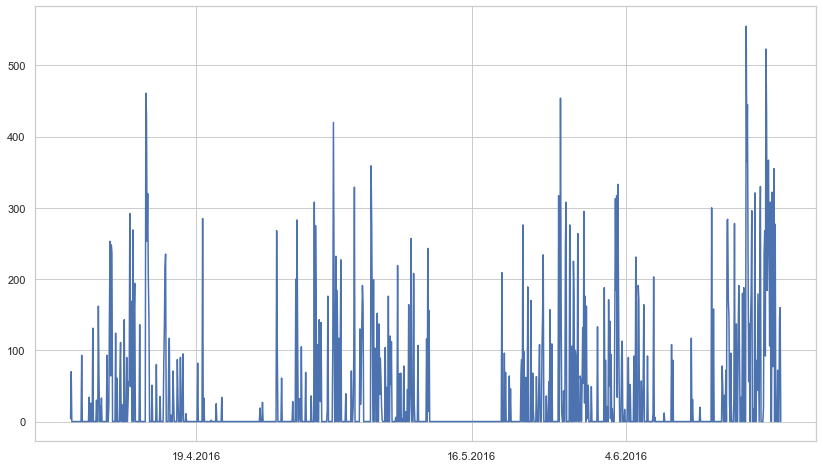

In [58]:
plt.plot(df.date, df.sby_need)
plt.xticks([204, 650, 900], ['19.4.2016', '16.5.2016', '4.6.2016'])
plt.show()

We observe that the number of drivers increases over the years. Is there a correlation with the number of calls?

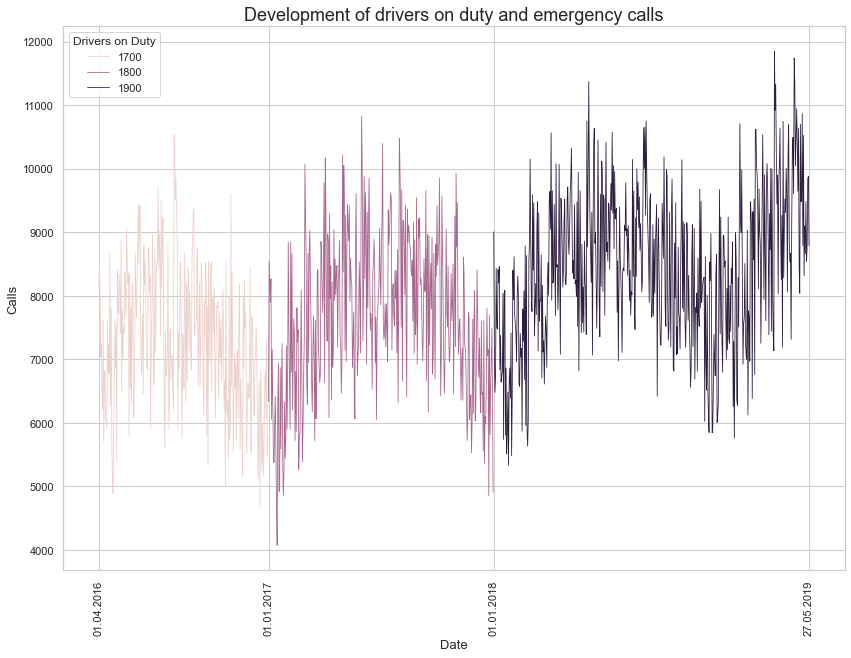

In [59]:
plt.figure(figsize=(14,10))
sns.set_style("whitegrid")
sns.lineplot(x='date', y='calls', hue='n_duty', data=df, linewidth = 0.8)
plt.xticks([0, 275, 640, 1151], ['01.04.2016', '01.01.2017', '01.01.2018', '27.05.2019'])
plt.xticks(rotation=90)

plt.legend(labels=["1700","1800", "1900"], title = "Drivers on Duty")
plt.xlabel('Date', fontsize=13)
plt.ylabel('Calls', fontsize=13)
plt.title('Development of drivers on duty and emergency calls', fontsize=18)

plt.savefig("dev_n_duty_calls.svg")
plt.show()

The graph shows that the number of drivers on duty increases with the number of calls.

What about the number of calls and the number of drivers on sick leave?

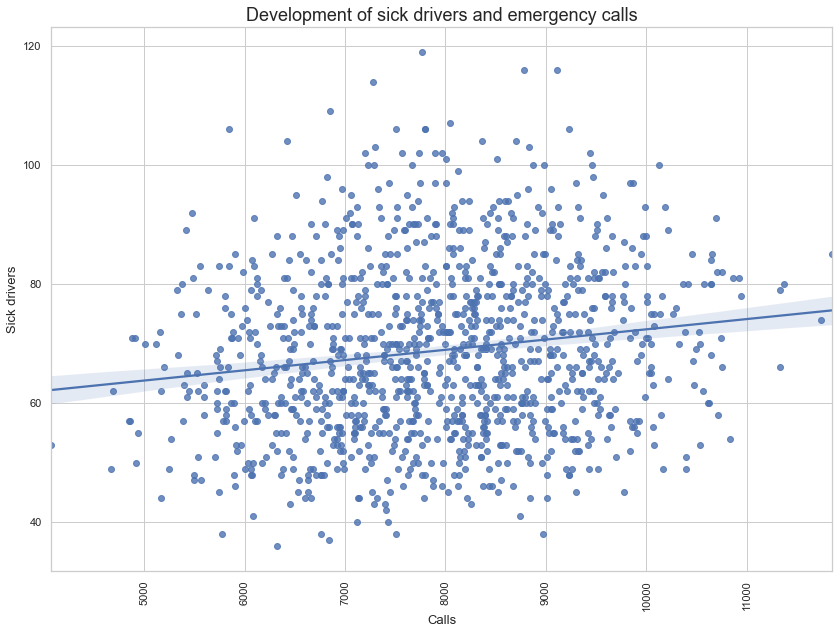

In [63]:
plt.figure(figsize=(14,10))
sns.set_style("whitegrid")
sns.regplot(x='calls', y='n_sick', data=df)
plt.xticks(rotation=90)

plt.title('Development of sick drivers and emergency calls', fontsize=18)
plt.xlabel('Calls', fontsize=13)
plt.ylabel('Sick drivers', fontsize=13)

plt.show()

If the number of calls increases, the number of sick drivers slightly increases

In [29]:
print(pearsonr(df.calls, df.n_sick)[0])

0.15537086860280808


The variables are weakly positively correlated.

In [30]:
print(pearsonr(df.calls, df.n_duty)[0])

0.36413536110780714


In [31]:
print(pearsonr(df.calls, df.sby_need)[0])

0.677467517263761


In [32]:
print(pearsonr(df.n_sick, df.sby_need)[0])

0.022321406858650947
